In [100]:
import pandas as pd
import dask as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats

In [101]:
df = pd.read_csv('data/jvf_data_realDist.csv')
df['da'] = pd.to_datetime(df['da'])
# df = df.set_index('da', drop=True)
df['jvf'] = df['jvf'].map({'Yes': 1, 'No': 0})

In [102]:
y = df['jvf']
X = df['disc_dist']
X_constant = sm.add_constant(X, prepend=False)

## Assumption Testing

1. Appropriate outcome type: Satisfied since outcome is either new entrent or incumbent
2. Linearity of independent variables and log-odds: Satisfied
3. No strongly influential outliers: Satisfied
4. Absence of multicollinearity: Satisfied since it's a simple Logistical Reg. with one IV
5. Independence of observations: Satisfied since data is time series observations
6. Sufficiently large sample size: Satisfied since the dataset consists of >500 observations

### Assumption 2: Continuous IV is linearly related to the log odds

In [103]:
df['disc_dist'] = pd.to_numeric(abs(df['disc_dist']))
df[['jvf', 'disc_dist']].to_csv('data/prepped-r.csv', index=False)

#### Results from Box-Tidwell test in R

In [104]:
Cannnot run R for some reason

SyntaxError: invalid syntax (1520996905.py, line 1)

#### Visual check

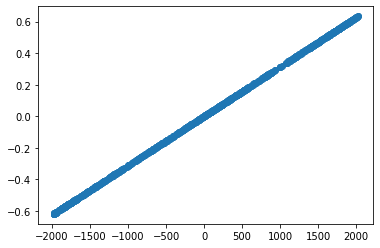

In [105]:
# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x=X.values, y=log_odds);
plt.show()

### Assumption 3: Lack of outliers

In [106]:
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df


,cooks_d,std_resid
0,0.004874,1.071565
1,0.004862,1.071108
2,0.004856,1.070879
3,0.001408,1.180070
4,0.001408,1.180070
...,...,...
984,0.005069,1.861429
985,0.001444,0.392381
986,0.001449,0.391646
987,0.001455,0.390790


In [107]:
# Set Cook's distance threshold
cook_threshold = 4 / len(X)
print(f"Threshold for Cook Distance = {cook_threshold}")

Threshold for Cook Distance = 0.004044489383215369


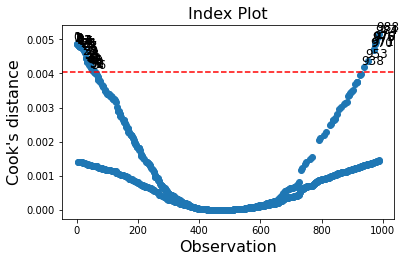

In [108]:
# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y=cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

In [109]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(X)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 4.6%


In [110]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(X)),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 0.0%


There are not outliers that can alter the reliability of the Logistical Regression Model

## Logistic Regression Model

In [111]:
model = smf.logit(formula="jvf~ disc_dist", data= df).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.626089
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    jvf   No. Observations:                  989
Model:                          Logit   Df Residuals:                      987
Method:                           MLE   Df Model:                            1
Date:                Thu, 09 Jun 2022   Pseudo R-squ.:               0.0006613
Time:                        12:00:38   Log-Likelihood:                -619.20
converged:                       True   LL-Null:                       -619.61
Covariance Type:            nonrobust   LLR p-value:                    0.3653
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6560      0.129      5.078      0.000       0.403       0.909
disc_dist   9.743e-05      0.000      0.905      0.365      -0.000       0.000
==============================================================================
"""

In [112]:
logit_model = GLM(y, X_constant, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    jvf   No. Observations:                  989
Model:                            GLM   Df Residuals:                      987
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -601.23
Date:                Thu, 09 Jun 2022   Deviance:                       1202.5
Time:                        12:00:38   Pearson chi2:                     986.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03649
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
disc_dist      0.0003   5.84e-05      5.950      0.0

<AxesSubplot:xlabel='disc_dist', ylabel='jvf'>

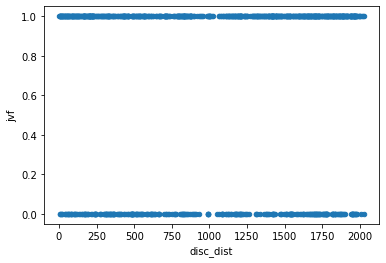

In [113]:
df.plot.scatter(x='disc_dist', y="jvf")